# 환경 세팅

## 한글폰트 설치 (런타임 재시작 필요)

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,091 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120901 files and dire

## lightgbm 버전 다운그레이드 (런타임 재시작 필요)
- lightgbm 3.3.2 버전

In [2]:
!pip install lightgbm==3.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0


## XGBOOST 설치

In [3]:
!pip install xgboost

## 런타임 재시작 후 설치 확인

In [1]:
import lightgbm
lightgbm.__version__

'3.3.2'

In [2]:
import xgboost
xgboost.__version__

'1.7.6'

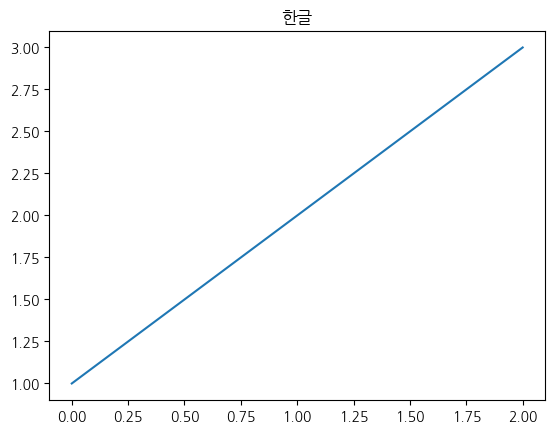

In [3]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

## 구글 드라이브 연동

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 데이터 불러오기

In [5]:
import pandas as pd

DATA_PATH = '/content/drive/MyDrive/세미프로젝트/data/' # 본인 경로 사용
data = pd.read_csv(DATA_PATH + '머신러닝.csv') # 본인 파일 이름 사용
data.head()

,요일,연도,역명,방향,시간대,혼잡도
0,평일,2017,서울역,상선,05시~06시,8.7
1,평일,2017,시청,상선,05시~06시,7.8
2,평일,2017,종각,상선,05시~06시,6.3
3,평일,2017,종로3가,상선,05시~06시,6.3
4,평일,2017,종로5가,상선,05시~06시,5.8


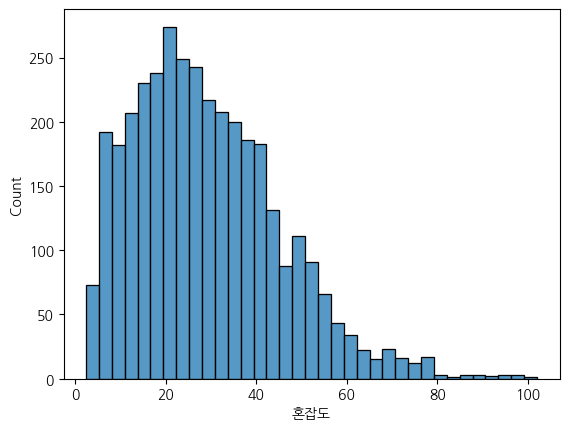

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.histplot(data=data, x='혼잡도')
plt.show()

# 종속변수 분포 정규화 (필요시)

In [7]:
# 추후 필요시 추가예정

# 머신러닝 코드

## sklearn.ensemble.RandomForestRegressor

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# 데이터를 독립변수(X)와 종속변수(y)로 나눕니다.
X = data[['시간대', '요일', '방향', '연도', '역명']]
y = data['혼잡도']

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['시간대', '요일', '방향', '역명']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

# 데이터를 학습, 검증, 테스트 데이터로 나눕니다.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.375, random_state=42)

# RandomForestRegressor 모델 정의
rf_reg = RandomForestRegressor(random_state=42)

# 파이프라인 정의
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer를 적용
    ('RF_reg', rf_reg)  # RandomForestRegressor 모델 사용
])

# 모델 학습
pipeline.fit(X_train, y_train)

# 모델을 파일로 저장합니다.
joblib.dump(pipeline, 'sklrf_reg.pkl')

# 검증 데이터를 사용하여 모델의 성능을 평가합니다.
y_val_pred = pipeline.predict(X_val)

# MAE, RMSE, R2 Score 계산
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
r2_val = r2_score(y_val, y_val_pred)

# 결과를 출력합니다.
print("Validation 성능 지표:")
print("Mean Absolute Error (MAE):", mae_val)
print("Root Mean Squared Error (RMSE):", rmse_val)
print("R-squared (R2):", r2_val)

# 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
y_test_pred = pipeline.predict(X_test)

# MAE, RMSE, R2 Score 계산
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# 결과를 출력합니다.
print("\nTest 성능 지표:")
print("Mean Absolute Error (MAE):", mae_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("R-squared (R2):", r2_test)

Validation 성능 지표:
Mean Absolute Error (MAE): 4.0496727357609705
Root Mean Squared Error (RMSE): 5.962448673856685
R-squared (R2): 0.8630854381176607

Test 성능 지표:
Mean Absolute Error (MAE): 4.298292016806723
Root Mean Squared Error (RMSE): 6.713044170729496
R-squared (R2): 0.8350163314904695


## sklearn.linear_model.LinearRegression

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib


# 독립/ 종속 변수 나누기
X = data[['시간대', '요일', '방향', '연도', '역명']]
y = data['혼잡도']

# 훈련+검증/ 테스트 데이터 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 훈련 / 검증 데이터 나누기
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.375, random_state=42)

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['시간대', '요일', '방향', '역명']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

# LinearRegression 모델 정의
lin_reg = LinearRegression()

# Pipeline을 정의합니다.
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer를 적용하여 원핫 인코딩 수행
    ('Lin_reg', lin_reg)  # LinearRegression 모델 사용
])

# Pipeline을 사용하여 모델을 학습합니다.
pipeline.fit(X_train, y_train)

# 학습된 모델을 파일로 저장합니다.
joblib.dump(pipeline, 'skllin_reg.pkl')

# 검증 데이터를 사용하여 모델의 성능을 평가합니다.
y_val_pred = pipeline.predict(X_val)

# 성능 지표 계산
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
r2_val = r2_score(y_val, y_val_pred)

# 결과를 출력합니다.
print("Validation 성능 지표:")
print("Mean Absolute Error (MAE):", mae_val)
print("Root Mean Squared Error (RMSE):", rmse_val)
print("R-squared (R2):", r2_val)

# 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
y_test_pred = pipeline.predict(X_test)

# 성능 지표 계산
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# 결과를 출력합니다.
print("\nTest 성능 지표:")
print("Mean Absolute Error (MAE):", mae_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("R-squared (R2):", r2_test)

Validation 성능 지표:
Mean Absolute Error (MAE): 6.5044999313845135
Root Mean Squared Error (RMSE): 8.77497131236767
R-squared (R2): 0.7034542224655058

Test 성능 지표:
Mean Absolute Error (MAE): 6.698048352489446
Root Mean Squared Error (RMSE): 9.398060850949891
R-squared (R2): 0.6766458404519113


## lightgbm.LGBMRegressor

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import joblib

# 독립/ 종속 변수 나누기
X = data[['시간대', '요일', '방향', '연도', '역명']]
y = data['혼잡도']

# 훈련+검증/ 테스트 데이터 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 훈련 / 검증 데이터 나누기
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.375, random_state=42)

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['시간대', '요일', '방향', '역명']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

# LightGBM 모델을 정의합니다.
lgb_reg = lgb.LGBMRegressor(random_state=42)


# Pipeline 정의
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer를 적용
    ('LGB_reg', lgb_reg)  # LGBMRegressor 모델 사용
])

# Pipeline을 사용하여 모델을 학습합니다.
pipeline.fit(X_train, y_train)

# 학습된 모델을 파일로 저장합니다.
joblib.dump(pipeline, 'lgb_reg.pkl')

# 검증 데이터를 사용하여 모델의 성능을 평가합니다.
y_val_pred = pipeline.predict(X_val)

# 성능 지표 계산
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
r2_val = r2_score(y_val, y_val_pred)

# 결과를 출력합니다.
print("Validation 성능 지표:")
print("Mean Absolute Error (MAE):", mae_val)
print("Root Mean Squared Error (RMSE):", rmse_val)
print("R-squared (R2):", r2_val)

# 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
y_test_pred = pipeline.predict(X_test)

# 성능 지표 계산
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# 결과를 출력합니다.
print("\nTest 성능 지표:")
print("Mean Absolute Error (MAE):", mae_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("R-squared (R2):", r2_test)

Validation 성능 지표:
Mean Absolute Error (MAE): 3.4763010088496418
Root Mean Squared Error (RMSE): 5.144690014479715
R-squared (R2): 0.8980660724189541

Test 성능 지표:
Mean Absolute Error (MAE): 3.893986827407669
Root Mean Squared Error (RMSE): 5.8788451589682
R-squared (R2): 0.8734721903908976


## xgboost.XGBRegressor

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# 데이터를 불러옵니다. (data는 데이터프레임으로 가정합니다)
# 데이터를 독립변수(X)와 종속변수(y)로 나눕니다.
X = data[['시간대', '요일', '방향', '연도', '역명']]
y = data['혼잡도']

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['시간대', '요일', '방향', '역명']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

# 데이터를 학습, 검증, 테스트 데이터로 나눕니다.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.375, random_state=1234)

# XGBRegressor 모델 정의
xgb_reg = XGBRegressor(random_state=1234)

# 파이프라인 정의
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer를 적용
    ('XGB_reg', xgb_reg)  # XGBRegressor 모델 사용
])

# 모델 학습
pipeline.fit(X_train, y_train)

# 모델을 파일로 저장합니다.
joblib.dump(pipeline, 'xgb_reg.pkl')

# 검증 데이터를 사용하여 모델의 성능을 평가합니다.
y_val_pred = pipeline.predict(X_val)

# MAE, RMSE, R2 Score 계산
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
r2_val = r2_score(y_val, y_val_pred)

# 결과를 출력합니다.
print("Validation 성능 지표:")
print("Mean Absolute Error (MAE):", mae_val)
print("Root Mean Squared Error (RMSE):", rmse_val)
print("R-squared (R2):", r2_val)

# 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
y_test_pred = pipeline.predict(X_test)

# MAE, RMSE, R2 Score 계산
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# 결과를 출력합니다.
print("\nTest 성능 지표:")
print("Mean Absolute Error (MAE):", mae_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("R-squared (R2):", r2_test)

Validation 성능 지표:
Mean Absolute Error (MAE): 2.7813301444832796
Root Mean Squared Error (RMSE): 4.119748394767431
R-squared (R2): 0.934237763292989

Test 성능 지표:
Mean Absolute Error (MAE): 2.8222988241526927
Root Mean Squared Error (RMSE): 4.272787852519948
R-squared (R2): 0.9291080976112376


# 주요 학습 변수

## sklearn.ensemble.RandomForestRegressor

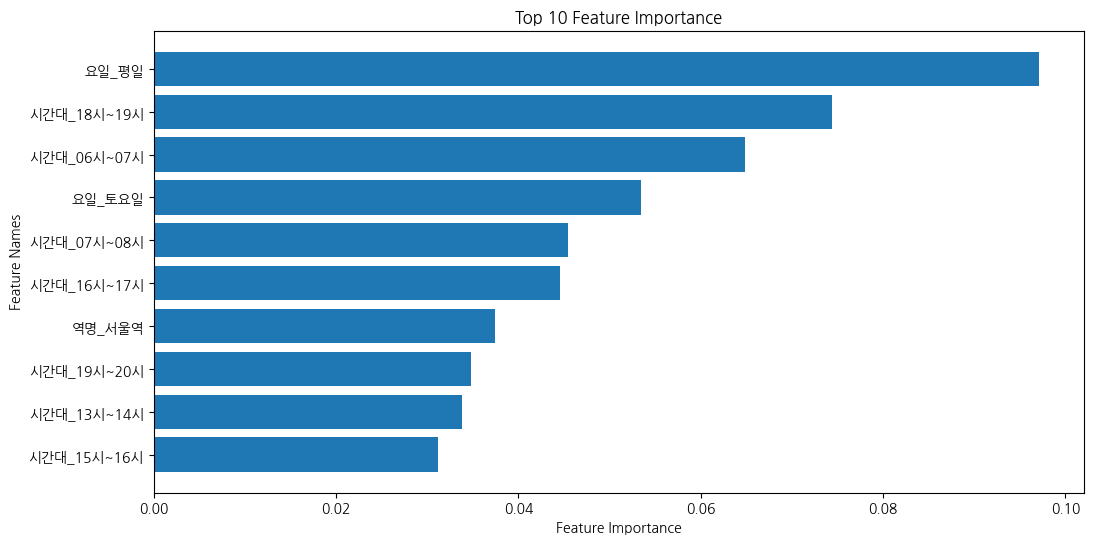

In [12]:
import joblib
import matplotlib.pyplot as plt

# .pkl 파일로부터 파이프라인 객체를 로드합니다.
loaded_pipeline = joblib.load('sklrf_reg.pkl')

# 파이프라인에서 모델을 추출합니다.
loaded_model = loaded_pipeline.named_steps['RF_reg']

# 모델에서 feature importance를 가져옵니다.
feature_importance = loaded_model.feature_importances_

# OneHot 인코딩을 사용한 경우, 칼럼명을 추출합니다.
column_transformer = loaded_pipeline.named_steps['preprocessor']
onehot_columns = list(column_transformer.named_transformers_['cat'].get_feature_names_out(input_features=['시간대', '요일', '방향', '역명']))
all_columns = onehot_columns  # OneHot 인코딩 칼럼명

# 특성 중요도와 칼럼명을 연결합니다.
feature_importance_with_names = list(zip(all_columns, feature_importance))

# 특성 중요도를 중요도 값으로 정렬합니다.
feature_importance_with_names.sort(key=lambda x: x[1], reverse=True)

# 상위 N개의 중요한 특성만 선택
top_n = 10  # 상위 10개 특성을 표시하도록 설정
top_features = feature_importance_with_names[:top_n]

# 중요한 특성과 중요도를 시각화합니다.
top_feature_names, top_feature_importance = zip(*top_features)
plt.figure(figsize=(12, 6))
plt.barh(top_feature_names, top_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Top {} Feature Importance'.format(top_n))
plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 표시하기 위해 y-축 뒤집기
plt.show()

## sklearn.linear_model.LinearRegression

In [13]:
# 마이너스 부호 깨짐 해결
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

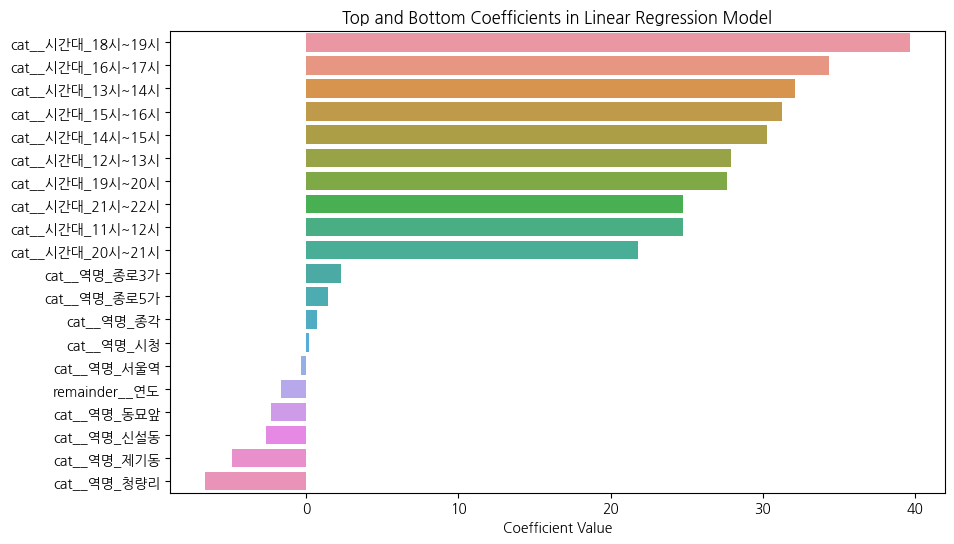

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 저장된 모델 파일을 불러옵니다.
model = joblib.load('skllin_reg.pkl')

# 모델의 계수(coef)를 가져옵니다.
coefficients = model.named_steps['Lin_reg'].coef_

# 독립 변수 X의 컬럼 이름을 가져옵니다.
columns = model.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns)

# 계수와 컬럼 이름을 DataFrame으로 만듭니다.
coef_df = pd.DataFrame({'Coefficient': coefficients}, index=columns)

# 계수를 내림차순으로 정렬합니다.
coef_sorted = coef_df.sort_values(by='Coefficient', ascending=False)

# 시각화를 위해 상위 10개와 하위 10개 계수만 선택합니다.
top_bottom_coef = pd.concat([coef_sorted.head(10), coef_sorted.tail(10)])

# 시각화 설정
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y=top_bottom_coef.index, data=top_bottom_coef)
plt.xlabel('Coefficient Value')
plt.title('Top and Bottom Coefficients in Linear Regression Model')
plt.show()

## lightgbm.LGBMRegressor

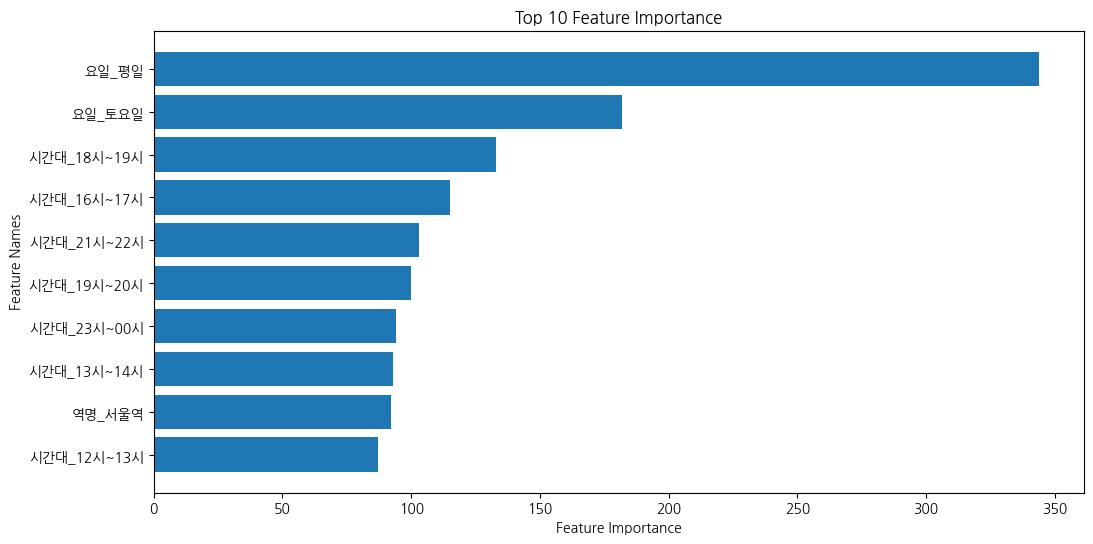

In [15]:
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt

# .pkl 파일로부터 파이프라인 객체를 로드합니다.
loaded_pipeline = joblib.load('lgb_reg.pkl')

# 파이프라인에서 모델을 추출합니다.
loaded_model = loaded_pipeline.named_steps['LGB_reg']

# 모델에서 feature importance를 가져옵니다.
feature_importance = loaded_model.feature_importances_

# OneHot 인코딩을 사용한 경우, 칼럼명을 추출합니다.
column_transformer = loaded_pipeline.named_steps['preprocessor']
onehot_columns = list(column_transformer.named_transformers_['cat'].get_feature_names_out(input_features=['시간대', '요일', '방향', '역명']))
all_columns = onehot_columns  # OneHot 인코딩 칼럼명

# 특성 중요도와 칼럼명을 연결합니다.
feature_importance_with_names = list(zip(all_columns, feature_importance))

# 특성 중요도를 중요도 값으로 정렬합니다.
feature_importance_with_names.sort(key=lambda x: x[1], reverse=True)

# 상위 N개의 중요한 특성만 선택
top_n = 10  # 상위 10개 특성을 표시하도록 설정
top_features = feature_importance_with_names[:top_n]

# 중요한 특성과 중요도를 시각화합니다.
top_feature_names, top_feature_importance = zip(*top_features)
plt.figure(figsize=(12, 6))
plt.barh(top_feature_names, top_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Top {} Feature Importance'.format(top_n))
plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 표시하기 위해 y-축 뒤집기
plt.show()

## xgboost.XGBRegressor

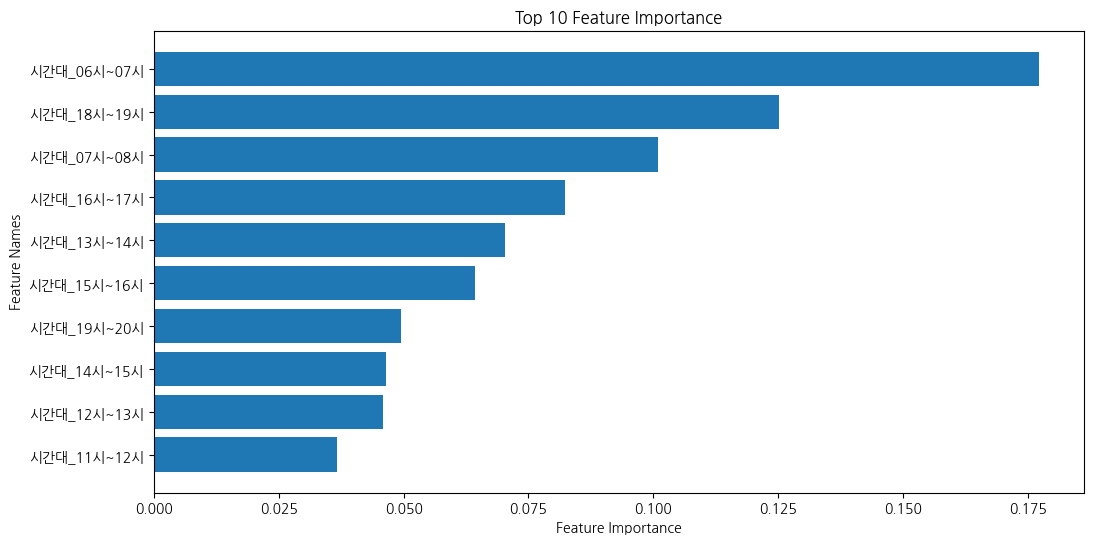

In [16]:
import joblib
import matplotlib.pyplot as plt

# .pkl 파일로부터 파이프라인 객체를 로드합니다.
loaded_pipeline = joblib.load('xgb_reg.pkl')

# 파이프라인에서 모델을 추출합니다.
loaded_model = loaded_pipeline.named_steps['XGB_reg']

# 모델에서 feature importance를 가져옵니다.
feature_importance = loaded_model.feature_importances_

# OneHot 인코딩을 사용한 경우, 칼럼명을 추출합니다.
column_transformer = loaded_pipeline.named_steps['preprocessor']
onehot_columns = list(column_transformer.named_transformers_['cat'].get_feature_names_out(input_features=['시간대', '요일', '방향', '역명']))
all_columns = onehot_columns  # OneHot 인코딩 칼럼명

# 특성 중요도와 칼럼명을 연결합니다.
feature_importance_with_names = list(zip(all_columns, feature_importance))

# 특성 중요도를 중요도 값으로 정렬합니다.
feature_importance_with_names.sort(key=lambda x: x[1], reverse=True)

# 상위 N개의 중요한 특성만 선택
top_n = 10  # 상위 10개 특성을 표시하도록 설정
top_features = feature_importance_with_names[:top_n]

# 중요한 특성과 중요도를 시각화합니다.
top_feature_names, top_feature_importance = zip(*top_features)
plt.figure(figsize=(12, 6))
plt.barh(top_feature_names, top_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Top {} Feature Importance'.format(top_n))
plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 표시하기 위해 y-축 뒤집기
plt.show()

# 예측

## Scikit-learn RandomForestRegressor

In [17]:
import joblib
import numpy as np

# 저장된 모델 파일을 불러옵니다.
model = joblib.load('sklrf_reg.pkl')

# 예측할 데이터 예시
new_data = pd.DataFrame({'시간대': ['18시~19시'], '요일': ['평일'], '방향': ['상선'], '연도': [2023], '역명': ['서울역']})

# 예측을 수행합니다.
predicted_congestion = model.predict(new_data)

# 예측 결과를 출력합니다.
print("예측 혼잡도:", predicted_congestion)

예측 혼잡도: [42.136]


## Scikit-learn LinearRegression

In [18]:
import joblib
import numpy as np

# 저장된 모델 파일을 불러옵니다.
model = joblib.load('skllin_reg.pkl')

# 예측할 데이터 예시
new_data = pd.DataFrame({'시간대': ['18시~19시'], '요일': ['평일'], '방향': ['상선'], '연도': [2023], '역명': ['서울역']})

# 예측을 수행합니다.
predicted_congestion = model.predict(new_data)

# 예측 결과를 출력합니다.
print("예측 혼잡도:", predicted_congestion)

예측 혼잡도: [40.39824521]


## LightGBM LGBMRegressor

In [19]:
import joblib
import numpy as np

# 저장된 모델 파일을 불러옵니다.
model = joblib.load('lgb_reg.pkl')

# 예측할 데이터 예시
new_data = pd.DataFrame({'시간대': ['18시~19시'], '요일': ['평일'], '방향': ['상선'], '연도': [2023], '역명': ['서울역']})

# 예측을 수행합니다.
predicted_congestion = model.predict(new_data)

# 예측 결과를 출력합니다.
print("예측 혼잡도:", predicted_congestion)

예측 혼잡도: [47.52861545]


## XGBoost XGBRegressor

In [20]:
import joblib
import numpy as np

# 저장된 모델 파일을 불러옵니다.
model = joblib.load('xgb_reg.pkl')

# 예측할 데이터 예시
new_data = pd.DataFrame({'시간대': ['18시~19시'], '요일': ['평일'], '방향': ['상선'], '연도': [2023], '역명': ['서울역']})

# 예측을 수행합니다.
predicted_congestion = model.predict(new_data)

# 예측 결과를 출력합니다.
print("예측 혼잡도:", predicted_congestion)

예측 혼잡도: [42.55107]


# 최적화 (진행중.............)

## LGBMRegressor

In [21]:
import lightgbm as lgb
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 데이터를 독립변수(X)와 종속변수(y)로 나눕니다.
X = data[['시간대', '요일', '방향', '연도', '역명']]
y = data['혼잡도']

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['시간대', '요일', '방향', '역명']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

# 데이터를 학습, 검증, 테스트 데이터로 나눕니다.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.375, random_state=42)

# LightGBM 모델 정의
lgb_reg = lgb.LGBMRegressor(random_state=42)

# 파이프라인 정의
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer를 적용
    ('LGB_reg', lgb_reg)  # LGBMRegressor 모델 사용
])

# 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'LGB_reg__learning_rate': [0.01, 0.1, 0.2, 0.3 , 0.4, 0.5],
    'LGB_reg__n_estimators': [50, 100, 150, 200, 250, 300],
    'LGB_reg__max_depth': [3, 4, 5, 6, 7],
    'LGB_reg__num_leaves': [31, 50, 100]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# GridSearchCV를 사용하여 최적 하이퍼파라미터 찾기
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적 모델 저장
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_lgb_reg_pipeline.pkl')

# 검증 데이터를 사용하여 모델의 성능을 평가합니다.
y_val_pred = best_model.predict(X_val)

# MAE, RMSE, R2 Score 계산
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
r2_val = r2_score(y_val, y_val_pred)

# 결과를 출력합니다.
print("\nValidation 성능 지표:")
print("Mean Absolute Error (MAE):", mae_val)
print("Root Mean Squared Error (RMSE):", rmse_val)
print("R-squared (R2):", r2_val)

# 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
y_test_pred = best_model.predict(X_test)

# MAE, RMSE, R2 Score 계산
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# 결과를 출력합니다.
print("\nTest 성능 지표:")
print("Mean Absolute Error (MAE):", mae_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("R-squared (R2):", r2_test)

최적 하이퍼파라미터: {'LGB_reg__learning_rate': 0.5, 'LGB_reg__max_depth': 7, 'LGB_reg__n_estimators': 300, 'LGB_reg__num_leaves': 31}

Validation 성능 지표:
Mean Absolute Error (MAE): 2.401931623169182
Root Mean Squared Error (RMSE): 3.390588575591987
R-squared (R2): 0.9557258203831422

Test 성능 지표:
Mean Absolute Error (MAE): 2.4821559746266995
Root Mean Squared Error (RMSE): 3.5609891928976136
R-squared (R2): 0.9535759251349174


## XGBRegressor

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# 데이터를 독립변수(X)와 종속변수(y)로 나눕니다.
X = data[['시간대', '요일', '방향', '연도', '역명']]
y = data['혼잡도']

# 범주형 열에 OneHot 인코딩을 적용
categorical_features = ['시간대', '요일', '방향', '역명']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 나머지 변수를 유지

# 데이터를 학습, 검증, 테스트 데이터로 나눕니다.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.375, random_state=42)

# XGBoost 모델 정의
xgb_reg = XGBRegressor(random_state=42)

# 파이프라인 정의
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer를 적용
    ('XGB_reg', xgb_reg)  # XGBRegressor 모델 사용
])

# 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'XGB_reg__learning_rate': [0.01, 0.1, 0.2, 0.3 , 0.4, 0.5],
    'XGB_reg__n_estimators': [50, 100, 150, 200, 250, 300],
    'XGB_reg__max_depth': [3, 4, 5, 6, 7],
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# GridSearchCV를 사용하여 최적 하이퍼파라미터 찾기
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적 모델 저장
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_xgb_reg_pipeline.pkl')

# 검증 데이터를 사용하여 모델의 성능을 평가합니다.
y_val_pred = best_model.predict(X_val)

# MAE, RMSE, R2 Score 계산
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
r2_val = r2_score(y_val, y_val_pred)

# 결과를 출력합니다.
print("\nValidation 성능 지표:")
print("Mean Absolute Error (MAE):", mae_val)
print("Root Mean Squared Error (RMSE):", rmse_val)
print("R-squared (R2):", r2_val)

# 테스트 데이터를 사용하여 모델의 성능을 평가합니다.
y_test_pred = best_model.predict(X_test)

# MAE, RMSE, R2 Score 계산
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

# 결과를 출력합니다.
print("\nTest 성능 지표:")
print("Mean Absolute Error (MAE):", mae_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("R-squared (R2):", r2_test)

최적 하이퍼파라미터: {'XGB_reg__learning_rate': 0.5, 'XGB_reg__max_depth': 4, 'XGB_reg__n_estimators': 300}

Validation 성능 지표:
Mean Absolute Error (MAE): 2.4817426405262712
Root Mean Squared Error (RMSE): 3.5952143881862746
R-squared (R2): 0.9502205699078468

Test 성능 지표:
Mean Absolute Error (MAE): 2.5772324843566956
Root Mean Squared Error (RMSE): 3.82048158757815
R-squared (R2): 0.946563479853922
